# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  | 10688813 |

In [354]:
from abc import ABC, abstractmethod
from typing import List
from scipy.special import expit
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml

mersenne = lambda idx: int(np.power(2, 32) * np.sin(idx + 1))
np.random.seed(mersenne(1))

mnist = fetch_openml('mnist_784', version=1)

## Gerando o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

--------------------------------------------
### Função generate_class(mu, sigma, n)
Essa função gera dados para uma única classe com base nos parâmetros fornecidos:

* mu: a média da distribuição normal que define a classe.
* sigma: o desvio padrão da distribuição normal que define a classe.
* n: o número de observações a serem geradas.

A função numpy.random.normal() é usada para gerar os dados de acordo de uma forma estável com a distribuição normal, retornando um array com n observações.

--------------------------------------------

### Função generate_data(classes)
Essa função gera dados para várias classes, onde cada classe é definida por um conjunto de parâmetros.

* classes: um dicionário onde as chaves representam os rótulos das classes e os valores são tuplas contendo o número de observações (n) e uma lista de pares (mu, sigma) representando os parâmetros da distribuição normal para cada coluna.
A função itera sobre as classes fornecidas, gerando dados para cada uma delas usando a função generate_class(). Em seguida, concatena os dados gerados para todas as classes e adiciona codificação one-hot para os rótulos das classes. Por fim, embaralha os dados e os retorna.

Em suma, esses dois métodos servem para facilitar gerar distribuições de dados separáveis e não separáveis para testar o MLP. 

--------------------------------------------

In [2]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_dataset(classes):
    data = []
    for label, params in classes.items():
        n, columns = params

        observations = []

        for mu, sigma in columns:
            observations.append(generate_class(mu, sigma, n))

        observations = np.array(observations).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1

        data.append(np.concatenate([observations, y_true], axis=1))

    sorted_data = np.concatenate(data, axis=0)

    return np.random.permutation(sorted_data)

## Visualizando o conjunto de dados

Para facilitar a visualização, vamos gerar dados com apenas 2 dimensões. Cada classe é representada por uma cor diferente.

Input features: 2
Output features: 3


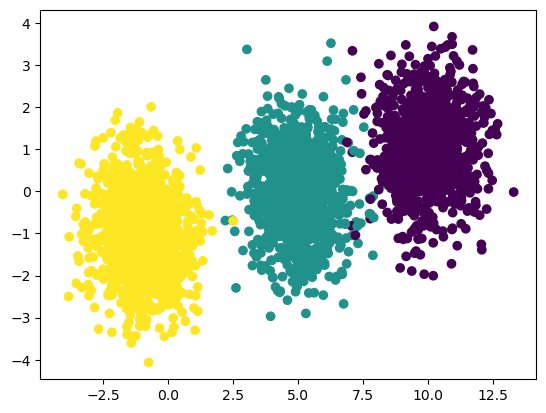

In [3]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1)]),
}

dataset = generate_dataset(classes)
input_features = dataset.shape[1] - len(classes)
output_features = len(classes)

print(f"Input features: {input_features}")
print(f"Output features: {output_features}")

x = dataset[:, :input_features]
y = dataset[:, input_features:]

plt.scatter(x[:, 0], x[:, 1], c=np.argmax(y, axis=1))

## Definindo uma Loss function

Essas classes são utilizadas para definir e calcular os erros dos modelos, especificamente a Cross Entropy, comum para problemas de classificação multiclasse.

------------------------------------
### Classe MSE
Essa classe implementa a função de _Mean Squared Error_, que parte da diferença entre as previsões e os rótulos verdadeiros, eleva ao quadrado e calcula a média.

__call__(self, y_true, y_pred): Calcula a perda com base no y_pred e nos _labels_ verdadeiros.

gradient(self, y_true, y_pred): Utilizado para retornar o gradiente calculado.

Em suma, a função MSE é uma função de perda comum para problemas de regressão, onde o objetivo é minimizar a diferença entre as previsões e os rótulos verdadeiros.

------------------------------------

In [102]:
class Module(ABC):
    def __call__(self, x):
        return self.forward(x)

    def pred(self, x):
        return np.argmax(self.forward(x), axis=1)

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, grad, lr=0.01):
        pass

In [517]:
class Loss(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass

    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass


class MSE(Loss):
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2, axis=1)

    def gradient(self, y_true, y_pred):
        return y_pred - y_true


class ReLU(Module):
    def __init__(self):
        super().__init__()
        self.x = None
        self.z = None
        
    def forward(self, x):
        self.x = x
        self.z = np.maximum(0, x)
        return self.z
    
    def backward(self, grad, lr=0.01):
        return grad * (self.z > 0)


class Tanh(Module):
    def __init__(self):
        super().__init__()
        self.x = None
        self.z = None
        
    def forward(self, x):
        self.x = x
        self.z = np.tanh(x)
        return self.z
    
    def backward(self, grad, lr=0.01):
        return grad * (1 - self.z ** 2)


class NaiveSigmoid(Module):
    def __init__(self):
        super().__init__()
        self.x = None
        self.z = None
        
    def forward(self, x):
        self.x = x
        self.z = 1 / (1 + np.exp(-x))
        return self.z
    
    def backward(self, grad, lr=0.01):
        return grad * self.z * (1 - self.z)
    
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        self.x = None
        self.z = None
        
    def forward(self, x):
        self.x = x
        self.z = np.array([expit(sample) for sample in x])
        return self.z
    
    def backward(self, grad, lr=0.01):
        return grad * self.z * (1 - self.z)

class Softmax(Module):
    def __init__(self):
        super().__init__()
        self.x = None
        self.z = None
        
    def forward(self, x):
        self.x = x
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.z = exps / np.sum(exps, axis=1, keepdims=True)
        return self.z
    
    def backward(self, grad, lr=0.01):
        return grad * self.z * (1 - self.z)

In [518]:
tan = Tanh()
relu = ReLU()
softmax = Softmax()
sigmoid = Sigmoid()
x = np.array([[-1, 0, 1, 2, 3]])
print(f"x, tanh(x): {x} -> {tan(x)}")
print(f"x, relu(x): {x} -> {relu(x)}")
print(f"x, softmax(x): {x} -> {softmax(x)}")
print(f"x, sigmoid(x): {x} -> {sigmoid(x)}")

x, tanh(x): [[-1  0  1  2  3]] -> [[-0.76159416  0.          0.76159416  0.96402758  0.99505475]]
x, relu(x): [[-1  0  1  2  3]] -> [[0 0 1 2 3]]
x, softmax(x): [[-1  0  1  2  3]] -> [[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]
x, sigmoid(x): [[-1  0  1  2  3]] -> [[0.26894142 0.5        0.73105858 0.88079708 0.95257413]]


In [519]:
criterion = MSE()
y_true = np.random.randn(1, 4)
y_pred = np.random.randn(1, 4)

loss = criterion(y_true, y_pred)
grad = criterion.gradient(y_true, y_pred)

print(f"Loss: {loss}")
print(f"Gradient: {grad}")

Loss: [1.08357485]
Gradient: [[ 0.27722503  0.85981923  1.28220451 -1.36898071]]


## Implementando o MLP em si

Classe MLP (_Multi-Layer Perceptron_):

* __init__(self, layers): O construtor inicializa os parâmetros da rede neural com base nas camadas fornecidas. _layers é uma lista que especifica o número de neurônios em cada camada.
* forward(self, x): Realiza a operação de feedforward na rede neural, aplicando a função de ativação camada à camada. É em essência um loop de produtos matriciais com pesos e passe das ativações (tornando o modelo não linear).
* backward(self, grad, lr=0.01): Faz o _backpropagation_ do gradiente na rede neural, atualizando os pesos e os viéses com base no gradiente descendente estocástico (SGD). (O valor grad é o gradiente da função de _loss_ em relação à saída da rede neural).
* pred(self, x=None, value=None): Retorna o y_hat da rede neural com base nas entradas fornecidas x ou em valores value.

Essa classe é uma implementação simples do que será utilizado para um exemplo de Autoencoder no final, com hidden layers não simétricas.

In [520]:
class Linear(Module):  # Fully connected layer
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = np.random.randn(in_features, out_features) - 0.5
        self.biases = np.random.randn(out_features)

        self.x = None
        self.z = None

    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.weights) + self.biases
        return self.z

    def backward(self, grad, lr=0.01):
        grad_w = np.dot(self.x.T, grad)
        grad_b = np.sum(grad, axis=0)
        
        grad = np.dot(grad, self.weights.T)
        
        self.weights -= lr * grad_w
        self.biases -= lr * grad_b
        
        return grad


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        super().__init__()

        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad, lr=0.01):
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr=lr)
        return grad

## Testando o _backpropagation_

Vamos testar o _backpropagation_ em uma rede neural simples com uma camada linear e uma função de erro _MSE_.

### Teste com uma camada linear

Para testar a camada linear, será utilizado um problema de regressão simples com uma única entrada e saída.

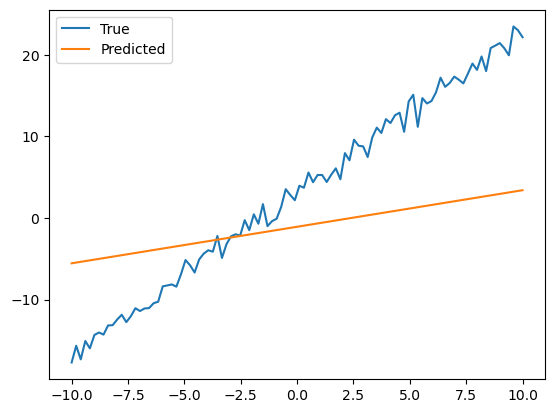

Epoch 0 - Loss: 9882.814720079445
Epoch 10 - Loss: 1487.6307984486841
Epoch 20 - Loss: 1231.0686852271388
Epoch 30 - Loss: 1022.8472668909255
Epoch 40 - Loss: 852.5419225504252
Epoch 50 - Loss: 713.2480000022078
Epoch 60 - Loss: 599.318534384913
Epoch 70 - Loss: 506.13483405978263
Epoch 80 - Loss: 429.9192390928771
Epoch 90 - Loss: 367.5819752163447
Epoch 100 - Loss: 316.59589462089934
Epoch 110 - Loss: 274.8940255809931
Epoch 120 - Loss: 240.78577758248258
Epoch 130 - Loss: 212.88840491521393
Epoch 140 - Loss: 190.07095026991962
Epoch 150 - Loss: 171.408395817223
Epoch 160 - Loss: 156.14416305707658
Epoch 170 - Loss: 143.65944118545374
Epoch 180 - Loss: 133.44810055268167
Epoch 190 - Loss: 125.096174206969


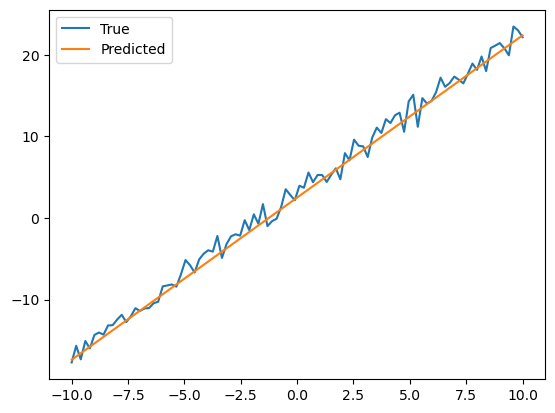

In [521]:
x = np.linspace(-10, 10, 100).reshape(-1, 1)
y = 2 * x + 3 + np.random.randn(100, 1)

input_features = 1
output_features = 1

linear = Linear(input_features, output_features)
criterion = MSE()
epochs = 200

# Initial predictions
pred = linear(x)
plt.plot(x, y, label='True')
plt.plot(x, pred, label='Predicted')
plt.legend()
plt.show()

for i in range(epochs):
    y_pred = linear(x)
    loss = criterion(y, y_pred)
    grad = criterion.gradient(y, y_pred)
    linear.backward(grad, lr=1e-4)
    batch_loss = np.sum(loss)
    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {batch_loss}")
        
pred = linear(x)
plt.plot(x, y, label='True')
plt.plot(x, pred, label='Predicted')
plt.legend()
plt.show()

## Treinando o modelo

A função train(dataset, model, criterion, lr=1e-4, epochs=1000) é responsável por treinar o modelo de acordo com os dados fornecidos.
O treinamento é feito por meio de um loop de épocas, onde cada época é composta por um loop de iterações sobre o conjunto de dados, mas é importante notar que o grosso da implementação está no método backward da classe MLP (que é um SGD padrão).

In [540]:
def train(x_train, y_train, model: Module, criterion: Loss, lr: float = 1e-3, epochs: int = 1000, batch_size=None):
    losses = [+np.inf]
    prev_loss = np.inf
    lr_decay_factor = 0.5
    patience = 10
    decay_counter = 0
    
    if batch_size is None:
        batch_size = x_train.shape[0]
    
    num_batches = (x_train.shape[0] + batch_size - 1) // batch_size
    
    for _ in tqdm(range(epochs)):
        epoch_loss = 0.0
        
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, x_train.shape[0])
            
            x_batch = x_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            y_pred = model(x_batch)
            loss = criterion(y_batch, y_pred)
            grad = criterion.gradient(y_batch, y_pred)

            model.backward(grad, lr=lr)

            epoch_loss += np.sum(loss)

        losses.append(epoch_loss)
        
        if np.abs(epoch_loss - prev_loss) < 1e-8 or np.isnan(epoch_loss):
            break

        if epoch_loss >= prev_loss:
            decay_counter += 1
            if decay_counter >= patience:
                lr *= lr_decay_factor
                decay_counter = 0
        else:
            decay_counter = 0

        prev_loss = epoch_loss

    return losses

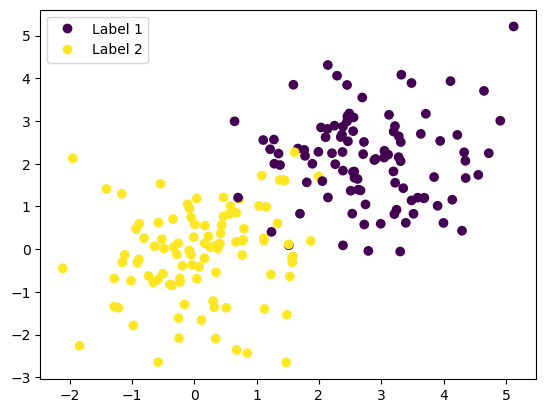

In [541]:
classes = {
    0: (100, [(3, 1), (2, 1)]),
    1: (100, [(0, 1), (0, 1)]),
}
dataset = generate_dataset(classes)

input_features = dataset.shape[1] - len(classes)
output_features = len(classes)
x = dataset[:, :input_features]
y = dataset[:, input_features:]
true = np.argmax(y, axis=1)

scatter = plt.scatter(dataset[:, 0], dataset[:, 1], c=np.argmax(dataset[:, 2:], axis=1))
plt.legend(handles=scatter.legend_elements()[0], labels=['Label 1', 'Label 2', 'Label 3', ...])
plt.show()

Loss: 0.1499908278913905
Accuracy: 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

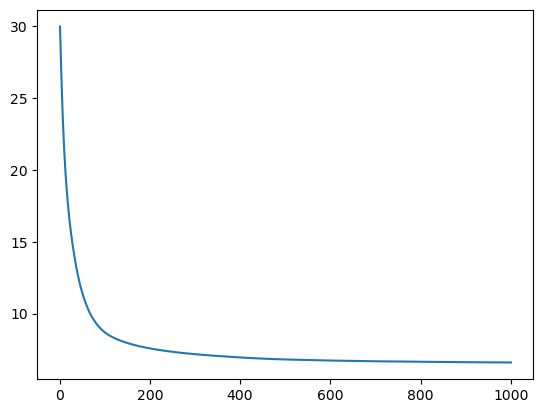

Loss: 6.591450809148737
Accuracy: 0.955


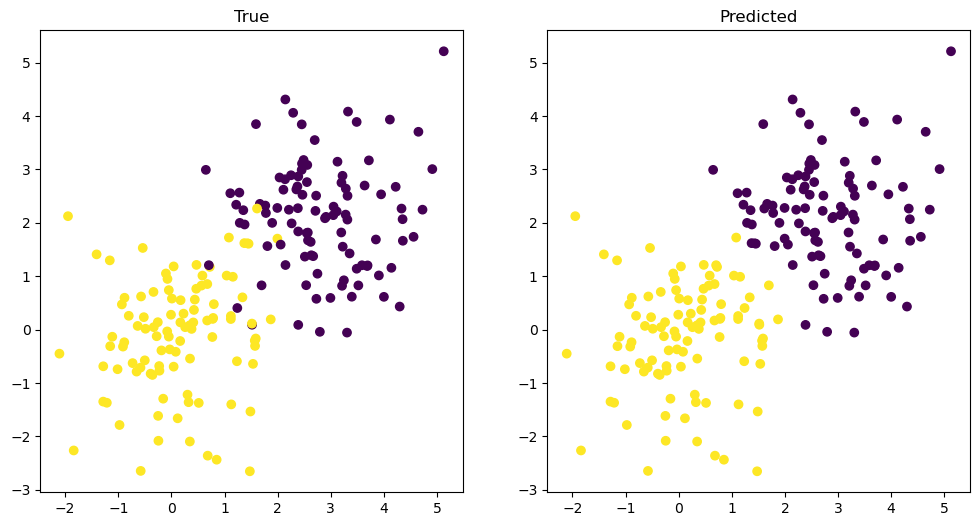

In [542]:
mlp = Sequential([
    Linear(input_features, 6),
    ReLU(),
    Linear(6, output_features),
    Softmax(),
])
criterion = MSE()

print(f"Loss: {np.mean(criterion(y, mlp(x)))}")
print(f"Accuracy: {np.mean(pred == true)}")

lr = 1e-3
epochs = 1000

losses = train(x, y, mlp, criterion, lr=lr, epochs=epochs)
plt.plot(losses)
plt.show()

pred = mlp.pred(x)

print(f"Loss: {np.sum(criterion(y, mlp(x)))}")
print(f"Accuracy: {np.mean(pred == true)}")

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x[:, 0], x[:, 1], c=np.argmax(y, axis=1))
axs[0].set_title('True')
axs[1].scatter(x[:, 0], x[:, 1], c=mlp.pred(x))
axs[1].set_title('Predicted')
plt.show()

## Autoencoder

Agora, vamos implementar um autoencoder, que é um tipo de rede neural que é treinada para copiar sua entrada para a saída. Ele é composto por duas partes: um codificador que transforma a entrada em uma representação interna e um decodificador que transforma a representação interna de volta na saída.

Aqui, vamos implementar um autoencoder simples com uma camada de entrada, uma camada oculta e uma camada de saída. O codificador e o decodificador são implementados como uma rede neural _feedforward_ com uma camada linear e uma função de ativação _tanh_.

In [543]:
class Autoencoder(Module):
    def __init__(self, layers: List[Module], output_layer: Module = None):
        super().__init__()

        self.encoder = Sequential(layers)
        self.decoder_layers = list(reversed(layers))
        
        if not isinstance(self.decoder_layers[0], Linear):
            self.decoder_layers.pop(0)
        
        for i, layer in enumerate(self.decoder_layers):
            if isinstance(layer, Linear):
                self.decoder_layers[i] = Linear(layer.weights.shape[1], layer.weights.shape[0])
            else:
                _class = layer.__class__
                self.decoder_layers[i] = _class()
        
        if output_layer is not None:
            self.decoder_layers.append(output_layer)
        self.decoder = Sequential(self.decoder_layers)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

    def backward(self, grad, lr=0.01):
        grad = self.decoder.backward(grad, lr=lr)
        grad = self.encoder.backward(grad, lr=lr)
        return grad
    
    @property
    def layers(self):
        return self.encoder.layers + self.decoder.layers

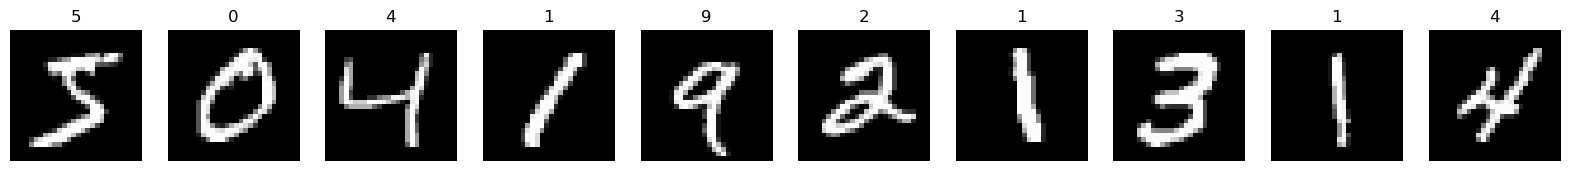

In [560]:
# Now, for the autoencoder, we will try to generate the same data
# Our test dataset will be the MNIST image datasetx = mnist.data.values[:10000]
y = mnist.target.values
x = mnist.data.values
x = x / 255

input_features = x.shape[1]
output_features = 10

# plot some images
_, axes = plt.subplots(1, 10, figsize=(20, 2))

# x is a dataframe
for i, ax in enumerate(axes):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(y[i])
    
plt.show()

In [577]:
autoencoder = Autoencoder([
    Linear(input_features, 64),
    ReLU(),
], output_layer=Sigmoid())
criterion = MSE()

for layer in autoencoder.layers:
    if isinstance(layer, Linear):
        print(f"Layer: Linear{layer.weights.shape}")
    else:
        print(f"Layer: {layer}")

Layer: Linear(784, 64)
Layer: <__main__.ReLU object at 0x7f375ceddbb0>
Layer: Linear(64, 784)
Layer: <__main__.Sigmoid object at 0x7f378a1db500>


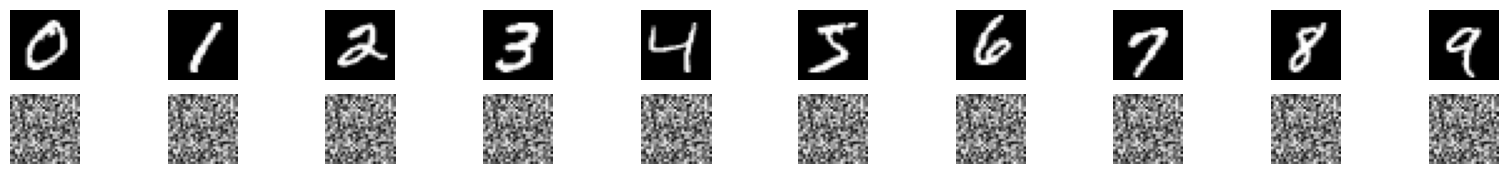

  0%|          | 0/20 [00:00<?, ?it/s]

In [578]:
_, axes = plt.subplots(2, 10, figsize=(20, 2))
for i in range(10):
    x_test = x[y == str(i)][0]
    x_true = x_test.reshape(28, 28)
    x_pred = autoencoder(x_test).reshape(28, 28)
    axes[0, i].imshow(x_true, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_pred, cmap='gray')
    axes[1, i].axis('off')
    
plt.show()

lr = 1e-3
epochs = 20
losses = train(x, x, autoencoder, criterion, lr=lr, epochs=epochs, batch_size=5096)

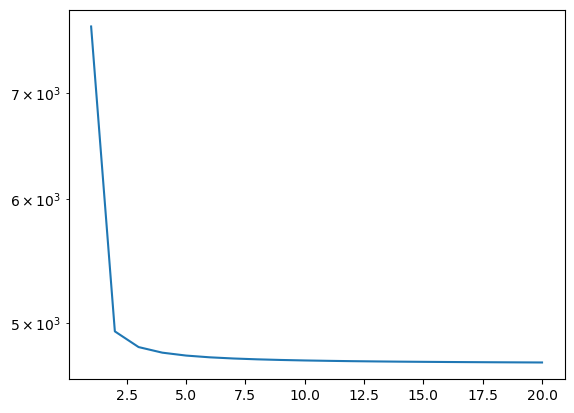

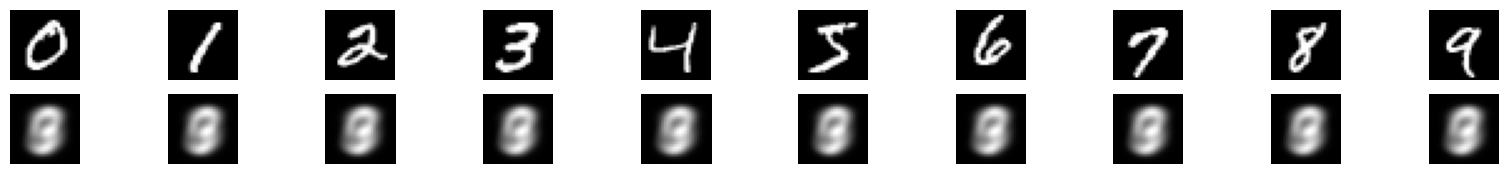

In [579]:
plt.plot(losses)
plt.yscale('log')
plt.show()

_, axes = plt.subplots(2, 10, figsize=(20, 2))
for i in range(10):
    x_test = x[y == str(i)][0]
    x_true = x_test.reshape(28, 28)
    x_pred = autoencoder(x_test).reshape(28, 28)
    axes[0, i].imshow(x_true, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_pred, cmap='gray')
    axes[1, i].axis('off')
    
plt.show()